# Calculating RNBS
Lindsay Fitzpatrick
ljob@umich.edu
08/19/2024
Updated: 10/09/2024

This script:
1. Opens the CSV files with the CFS forecasts. 
2. Runs the forecast through the trained Gaussian Process model. 
3. Produces an ensemble of RNBS forecasts for each of the Great Lakes.
4. Saves the forecast to a CSV file.
5. Creates a timeseries plot and saves it as a PNG file. 

This script needs the following files:

- input
    - GL_mask.nc
    - GP_trained_model.joblib
    - x_scaler.joblib
    - y_scaler.joblib
- data
    - CFS_EVAP_forecasts_Sums_CMS.csv
    - CFS_PCP_forecasts_Sums_CMS.csv
    - CFS_TMP_forecasts_Avgs_K.csv

In [12]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import joblib
import calendar

User Input

In [13]:
# Directory to downloaded/processed CFS data
dir = 'C:/Users/fitzpatrick/Desktop/NBS-Predictor-MVP-main/notebooks/production'
#dir = './'

# Read in the CSVs
pcp_data = pd.read_csv(dir+'/data/CFS_PCP_forecasts_Sums_CMS.csv',sep=',')
tmp_data = pd.read_csv(dir+'/data/CFS_TMP_forecasts_Avgs_K.csv',sep=',')
evap_data = pd.read_csv(dir+'/data/CFS_EVAP_forecasts_Sums_CMS.csv',sep=',')

# Open the trained model(s)
# For the MVP we are only going to use the GP model since it has the best performance
GP_model = joblib.load(dir+'/input/GP_trained_model.joblib')

c:\Users\fitzpatrick\AppData\Local\miniconda3\envs\mvpenv\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator GaussianProcessRegressor from version 1.5.0 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


# Define Functions

Determine the mean/median, min, and max RNBS values for each month from the ensemble members.

In [50]:
def calculate_median_confidence(df,lake):
    median = df.groupby(['year', 'month'])[lake].median().reset_index()
    #min = df.groupby(['year', 'month'])[lake].min().reset_index()
    #max = df.groupby(['year', 'month'])[lake].max().reset_index()

    # Calculate the 2.5th and 97.5th percentiles for the confidence band
    lower_bound = df.groupby(['year', 'month'])[lake].quantile(0.025).reset_index()
    upper_bound = df.groupby(['year', 'month'])[lake].quantile(0.975).reset_index()

    return median, lower_bound, upper_bound

Calculate the number of seconds in a month based on the month and the year. This is used to calculate units between cms and mm.

In [44]:
def seconds_in_month(year, month):
    # Number of days in the month
    num_days = calendar.monthrange(year, month)[1]
    # Convert days to seconds
    return num_days * 24 * 60 * 60

Convert a dataframe in [cms] to [mm].

In [15]:
def convert_cms_to_mm(df_cms):

    # Create a copy of the dataframe so we aren't altering the df_cms
    df_mm = df_cms.copy()

    sa_su = 82097*1000000
    sa_mh = (57753 + 5956)*1000000
    sa_er = 25655*1000000
    sa_on = 19009*1000000
    
    # Calculate the number of seconds for each month
    df_mm['seconds'] = df_mm.apply(lambda row: seconds_in_month(int(row['year']), int(row['month'])), axis=1)

    # value_cms / surface_area * seconds_in_a_month = m * 1000 = mm
    for column in df_mm.columns:
        if column.startswith("er"):
            df_mm[column] = df_mm[column] / sa_er * df_mm['seconds'] * 1000
        elif column.startswith("su"):
            df_mm[column] = df_mm[column] / sa_su * df_mm['seconds'] * 1000
        elif column.startswith("mih"):
            df_mm[column] = df_mm[column] / sa_mh * df_mm['seconds'] * 1000
        elif column.startswith("on"):
            df_mm[column] = df_mm[column] / sa_on * df_mm['seconds'] * 1000

    # Deleting column 'seconds'
    df_mm.drop('seconds', axis=1)

    return df_mm

Function to create a 4 plot figure displaying the RNBS forecast for each lake going out 9 months.

In [54]:
def plot_rnbs_forecast(x_values, data_dict):
    """
    Plots RNBS forecasts for different lakes.

    Parameters:
    - x_values: array-like, the x-axis values (e.g., months)
    - data_dict: dictionary containing data for each lake. The keys are lake names, and the values are tuples containing
                 (mean, min, max) for that lake.

    The dictionary should be formatted as:
    {
        'Lake Superior': (mean_su, min_su, max_su),
        'Lake Erie': (mean_er, min_er, max_er),
        'Lake Ontario': (mean_on, min_on, max_on),
        'Lake Mich-Huron': (mean_mh, min_mh, max_mh)
    }
    """
    # Create a 4x1 grid of subplots
    fig, axs = plt.subplots(4, 1, figsize=(10, 10), sharex=True)
    
    # Titles for the subplots
    titles = [
        'Lake Superior 9-month RNBS Forecast',
        'Lake Erie 9-month RNBS Forecast',
        'Lake Ontario 9-month RNBS Forecast',
        'Lake Mich-Huron 9-month RNBS Forecast'
    ]
    
    for i, (mean, min_val, max_val) in enumerate(data_dict.values()):
        axs[i].plot(x_values, mean, color='red', linestyle='-', linewidth=1.5, label='Median')
        axs[i].axhline(y=0, color='black', linestyle='-', linewidth=1.2)
        axs[i].fill_between(x_values, min_val, max_val, color='gray', alpha=0.2, label='95% Confidence')
        axs[i].set_ylabel('RNBS [mm]')
        axs[i].set_title(titles[i])
        axs[i].set_xlim(0, len(mean) - 1)
        axs[i].set_ylim(min_val.min() - 10, max_val.max() + 10)
        axs[i].grid(True, linestyle='--', alpha=0.6)

    # Place the legend on the top plot
    axs[0].legend(loc='upper right')
    # Set x-tick labels for the last subplot
    axs[-1].set_xticklabels([calendar.month_abbr[month] for month in median_su['month'][:len(mean)]])
    
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.savefig(dir+f'RNBS_forecasts.png', bbox_inches='tight')
    plt.show()

# Begin Script

Read in the precip, evap, and air temp forecasts from the CFS forecast. We add the totals for Mich and 
Huron together with the exception of air temp where we take the average of the two lakes. We put them all
into a new dataframe 'X' which will be our features to run through the models.

In [18]:
X = pd.DataFrame({
    'su_pcp': pcp_data['sup_lake'],
    'er_pcp': pcp_data['eri_lake'],
    'on_pcp': pcp_data['ont_lake'],
    'mh_pcp': pcp_data['mic_lake']+pcp_data['hur_lake'],
    'su_evap': evap_data['sup_lake'],
    'er_evap': evap_data['eri_lake'],
    'on_evap': evap_data['ont_lake'],
    'mh_evap': evap_data['mic_lake']+evap_data['hur_lake'],
    'su_tmp': tmp_data['sup_lake'],
    'er_tmp': tmp_data['eri_lake'],
    'on_tmp': tmp_data['ont_lake'],
    'mh_tmp': (tmp_data['mic_lake']+tmp_data['hur_lake'])/2
})

Standardize the data

In [19]:
# Standardize the data
x_scaler = joblib.load(dir+'/input/x_scaler.joblib')
y_scaler = joblib.load(dir+'/input/y_scaler.joblib')
X_scaled = x_scaler.transform(X)

c:\Users\fitzpatrick\AppData\Local\miniconda3\envs\mvpenv\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.0 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Run the scaled data through the trained GP model. Put the results into a new dataframe. Add the month
as a column in the dataframe. Then save the RNBS forecast to a CSV. 

In [20]:
# Predict RNBS using GP
y_pred_scaled = GP_model.predict(X_scaled)

y_pred = y_scaler.inverse_transform(y_pred_scaled) # unscale the predictions
df_y_pred = pd.DataFrame(y_pred, columns=['sup', 'eri', 'ont', 'mih'])

Add the forecast month and year as columns in the new dataframe along side the RNBS forecast.

In [21]:
df_y_pred['month'] = pcp_data['forecast_month'].astype(int)
df_y_pred['year'] = pcp_data['forecast_year'].astype(int)

Before plotting, we can remove any forecasts that are from previous months that have passed and only look at the future months forecasts.

In [26]:
current_day = datetime.now().day
current_month = datetime.now().month
current_year = datetime.now().year

# Determine filtering condition based on the day of the month
if current_day >= 26:
    # Remove this month and all previous months
    filtered_y_pred = df_y_pred[
        (df_y_pred['year'] > current_year) |
        (df_y_pred['year'] == current_year) & (df_y_pred['month'] > current_month)
    ]
    print(f"First month forecast: {current_month+1}")
else:
    # Keep this month
    filtered_y_pred = df_y_pred[
        (df_y_pred['year'] > current_year) |
        ((df_y_pred['year'] == current_year) & (df_y_pred['month'] >= current_month))
    ]
    print(f"First month forecast: {current_month}")

First month forecast: 10


Save the RNBS forecast to a CSV file.

In [27]:
filtered_y_pred.to_csv(dir+'RNBS_forecasts.csv',sep=',',index=False)

Convert RNBS from [cms] to [mm] before plotting for easier to interpret visualization.

In [45]:
df_y_mm = convert_cms_to_mm(filtered_y_pred)

Calculate the median of the ensemble forecasts for each month as well as the 95% confidence band.

In [46]:
median_su, min_su, max_su = calculate_median_confidence(df_y_mm,'sup')
median_er, min_er, max_er = calculate_median_confidence(df_y_mm,'eri')
median_on, min_on, max_on = calculate_median_confidence(df_y_mm,'ont')
median_mh, min_mh, max_mh = calculate_median_confidence(df_y_mm,'mih')

Plot the forecast.

C:\Users\fitzpatrick\AppData\Local\Temp\1\ipykernel_3492\2078509334.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[-1].set_xticklabels([calendar.month_abbr[month] for month in median_su['month'][:len(mean)]])


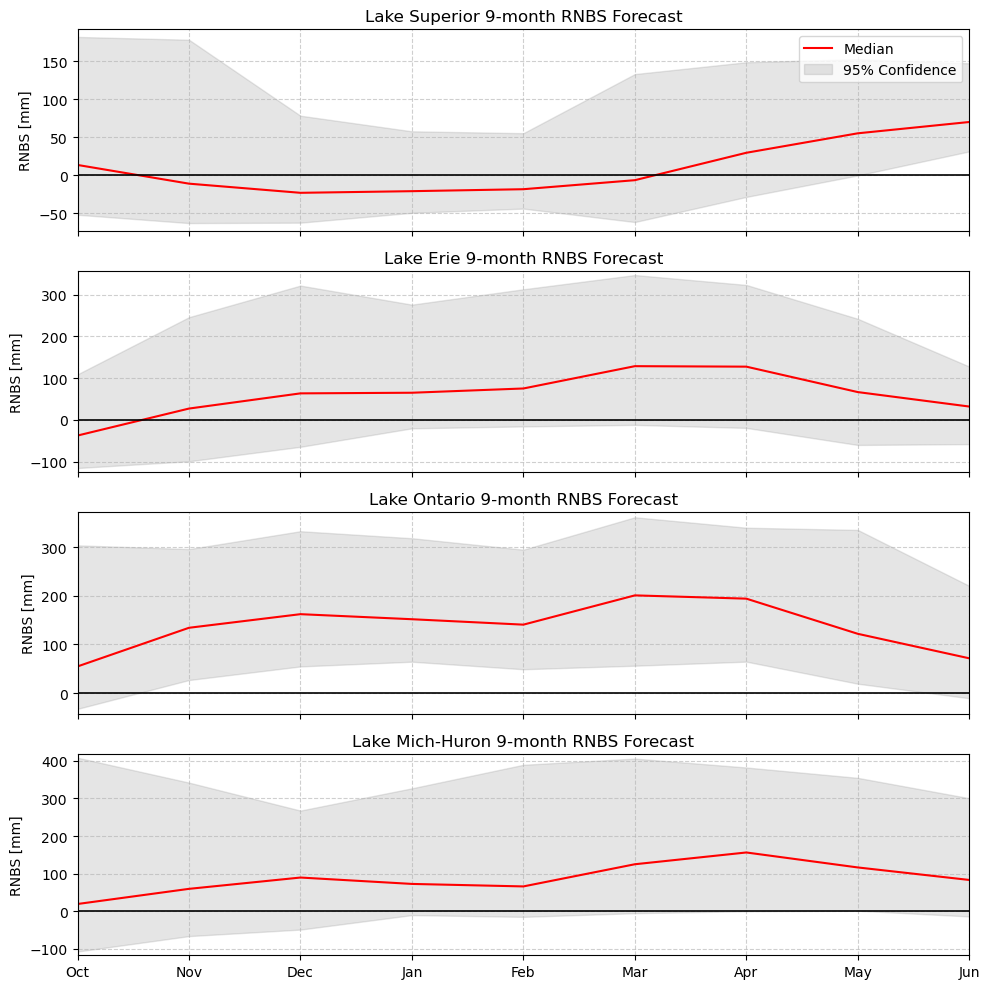

In [55]:
x_values = np.arange(len(median_su['sup']))  # x-axis values
data_dict = {
    'Lake Superior': (median_su['sup'], min_su['sup'], max_su['sup']),
    'Lake Erie': (median_er['eri'], min_er['eri'], max_er['eri']),
    'Lake Ontario': (median_on['ont'], min_on['ont'], max_on['ont']),
    'Lake Mich-Huron': (median_mh['mih'], min_mh['mih'], max_mh['mih'])
}

plot_rnbs_forecast(x_values, data_dict)